# Declarations

In [2]:
%pylab inline 

import numba
from numba import jit
import numpy as np
import numpy


Populating the interactive namespace from numpy and matplotlib


# Numerical solutions of (partial) differential equations

The techniques discussed herein can in principle be used to solve any set of partial differential equations, but the general case gets hairy and rather difficult quite quickly, and often requires years of experience to master. We will focus on a much simpler familiy of differential equations, namely [Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation).

Poisson's equation in 1D looks like 

$$
\frac{\mathrm d^2 f}{\mathrm d x^2} = b(x)
$$

where $f(x)$ is an unknown function and $b(x)$ is known. In 2D it looks like

$$
\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = b(x, y)
$$

where $f(x, y)$ is an unknown function and $b(x,y)$ is known. In 3D it looks like

$$
\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2} = b(x, y, z)
$$

where $f(x, y, z)$ is an unknown function and $b(x, y, z)$ is known.

For simplicity we'll focus our derivations on the 1D case, but the strategy discussed here easily generalize to two and three dimensions. We will develop the final algorithm for 2D and 3D towards the end, but skip most of the details.

## Turning a differential equation into a matrix equation

Partial differential equations are often notoriously hard to solve analytically, and techniques such as [the method of characteristics](https://en.wikipedia.org/wiki/Method_of_characteristics) and [the Laplace transform](https://en.wikipedia.org/wiki/Laplace_transform_applied_to_differential_equations) are useful to solving some cases, but certain cases are often impossible or near impossible to solve exactly. 

## Boundary conditions

When solving a differential equation we have the choice of imposing different boundary conditions. Usually we have the choice of specifying the value or the derivative at the boundary, or a mixture of the two. We'll focus on the former case here. Even when specifying the boundary values we have a few choices of *where* to place the boundaries.


### Explicit cell boundaries

The boundary values are included in the grid itself, and defined at the center of each grid cell at the edge of the grid, and they are set to a constant value, typically zero. 

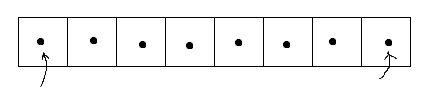

A single iteration of Jacobi's method would look like  

```py
def step_jacobi(x, b):
    N = len(x)
    for i in range(1, N-1):
        rhs   = b[i]
        left  = x[i-1]
        right = x[i+1]
        x[i]  = (rhs + left + right) / 2.0
```

where `x[0]` and `x[N-1]` already contain the boundary values. 

### Implicit cell boundaries

The boundary values are not explicitly included in the grid, but are assumed to be implicitly defined for virtual grid cells just outside the main grid. 

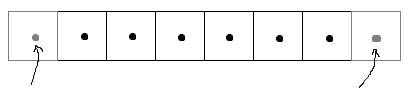

A single iteration of Jacobi's method would look like

```py
def step_jacobi(x, b, boundary_left, boundary_right):
    N = len(x)
    for i in range(0, N):
        rhs   = b[i]
        left  = x[i-1] if i > 0   else boundary_left
        right = x[i+1] if i < N-1 else boundary_right
        x[i]  = (rhs + left + right) / 2.0
```

### Implicit edge boundaries

The boundary values are not explicitly included in the grid, but are assumed to be implicitly defined for a virtual edge between the first and last cells in the grid and virtual cells just outside the grid. The values in the virtual cells are then implicitly defined such that at the edge the value is equal to the boundary value. 

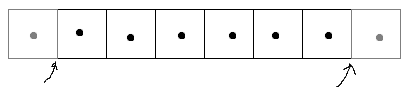

A single iteration of Jacobi's method would look like
```py
def step_jacobi(x, b, boundary_left, boundary_right):
    N = len(x)
    for i in range(0, N):
        rhs   = b[i]
        left  = x[i-1] if i > 0   else 2 * boundary_left  - x[0]    # (x[-1]  + x[0]) / 2 = boundary_left
        right = x[i+1] if i < N-1 else 2 * boundary_right + x[N-1]  # (x[N-1] + x[N]) / 2 = boundary_right
        x[i]  = (rhs + left + right) / 2.0
```

We are not limited to placing the boundary exactly at the edge of a cell, but it can be anywhere inbetween cell centers as well. If `x[0]` is the first grid value and `x[-1]` is the (unknown) value in the virtual cell to the left of the first grid cell, then

```
r = (pos_boundary - pos[-1]) / (pos[0] - pos[-1])
x[-1] * (1 - r) + x[0] * r = boundary_value
```

Turns out this scheme will be the most useful for later, as it generalizes the multigrid scheme described below to arbitrary sizes.

# General purpose Multigrid coarsening scheme

## The error equation

Our goal is to solve the matrix equation $Ax = b$ for some unknown $x$ given a matrix $A$ and a right hand side $b$. 

If we have an approximate solution $y \neq x$, then $Ay \neq Ax$, i.e. $Ay \neq b$. 

We can define the *residual*, $r = b - Ay$, which is then a measure of how close we are to the true solution $x$. 

The true error is $e = x - y$. If we can calculate $e$ given $y$ then we can calculate $x$.

We can relate the residual and the error by applying the matrix $A$ to the error and do some algebra: 

$$Ae = A(x-y) = Ax - Ay = b - Ay = r,$$

i.e. the error is the solution to the matrix equation $Ae = r$. 

In other words, if we have an approximate solution $y \neq x$ we can calculate the residual $r = b - Ay$, which we can then use to solve the *error equation* $Ae = r$. Having found the error $e$ we can calculate the true solution $x = y + e.$

Solving $Ae = r$ has one major advantage over $Ax = b$, even though it's *the same* matrix equation -- it only has a different right hand side vector. In particular, the error will necessarily get smaller the better our approximation is. This means we can gradually improve our solution using an iterative method.

## The multigrid algorithm

The core of a multigrid algorithm is not to approximate $Ax = b$ directly on a coarser grid, but instead to approximate $Ae = r$ on the coarser grid based on some initial guess $y$. Given the approximate error computed on the coarse grid we can interpolate that error onto the finer grid, and use it to update our approximation $y$. The next iteration of the algorithm we will start with a smaller $r$, since $y$ is closer to $x$ (but not identical, since we only approximate $e$).

0.46875 1.8823529411764706 0.8823529411764706
0.4375 1.7777777777777777 0.7777777777777778
0.375 1.6 0.6
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


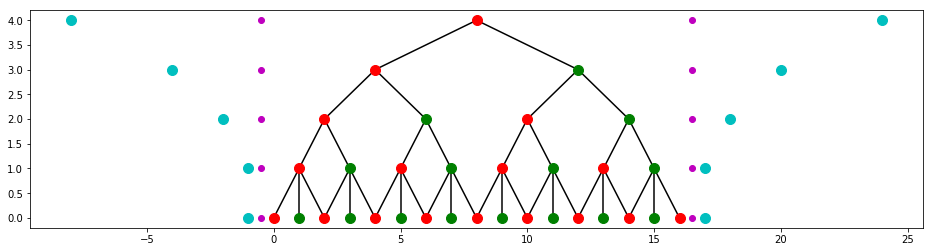

0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0


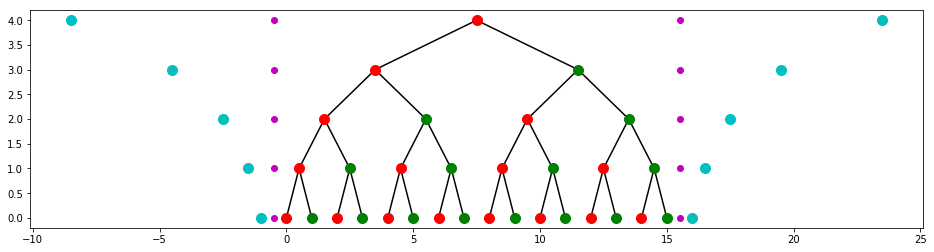

0.0625 1.0666666666666667 0.06666666666666667
0.125 1.1428571428571428 0.14285714285714285
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


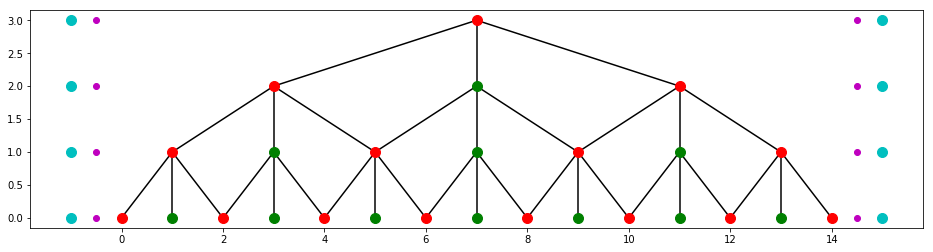

0.125 1.1428571428571428 0.14285714285714285
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0
0.5 2.0 1.0


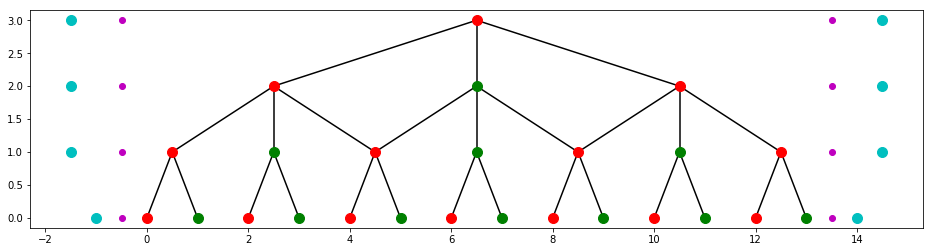

0.1875 1.2307692307692308 0.23076923076923078
0.375 1.6 0.6
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


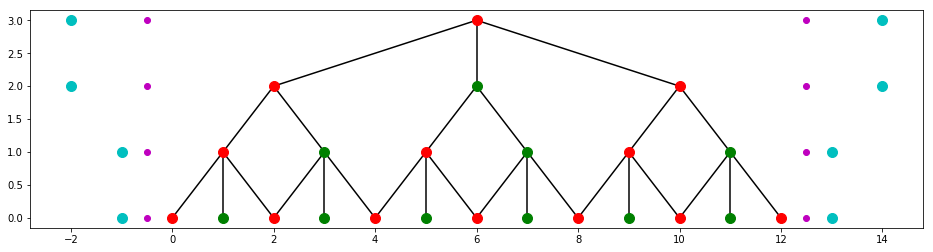

0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0


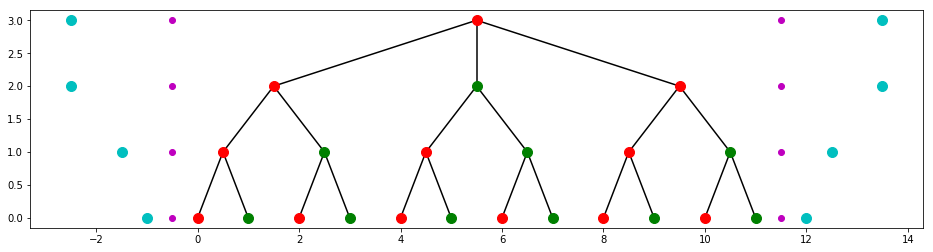

0.3125 1.4545454545454546 0.45454545454545453
0.125 1.1428571428571428 0.14285714285714285
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


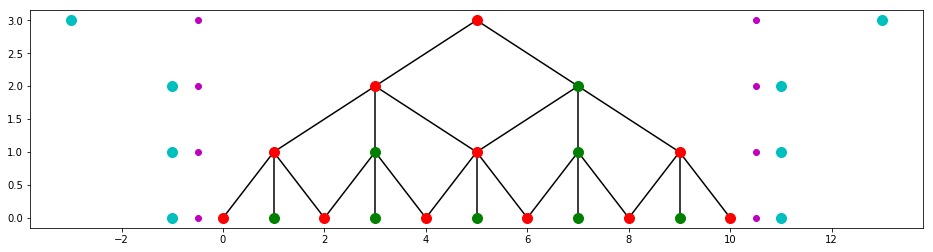

0.375 1.6 0.6
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0
0.5 2.0 1.0


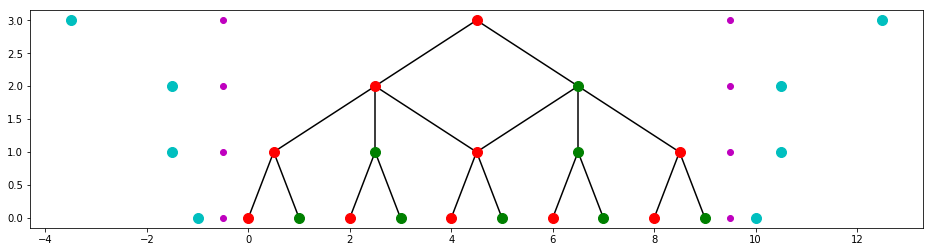

0.4375 1.7777777777777777 0.7777777777777778
0.375 1.6 0.6
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


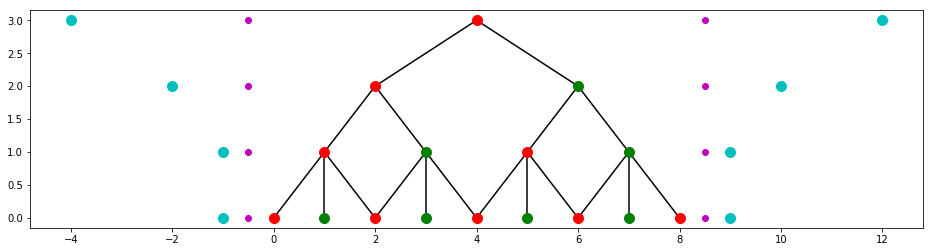

0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0


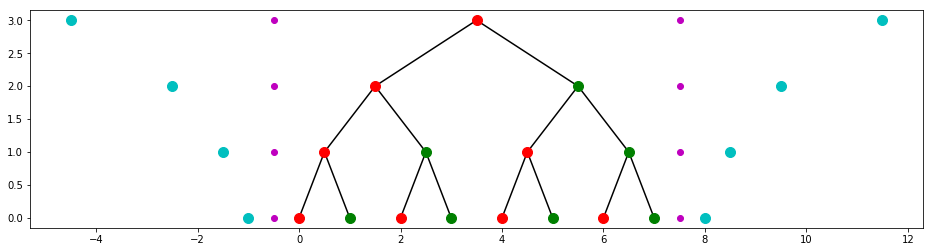

0.125 1.1428571428571428 0.14285714285714285
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


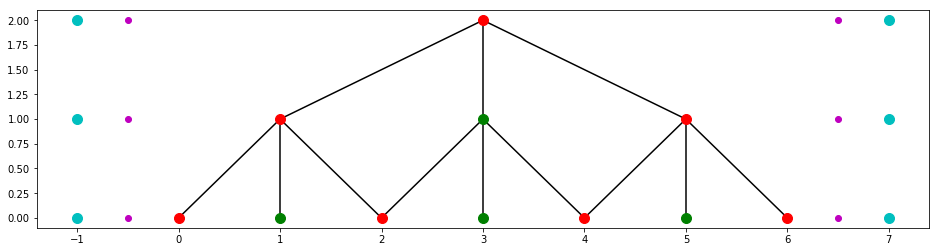

0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0
0.5 2.0 1.0


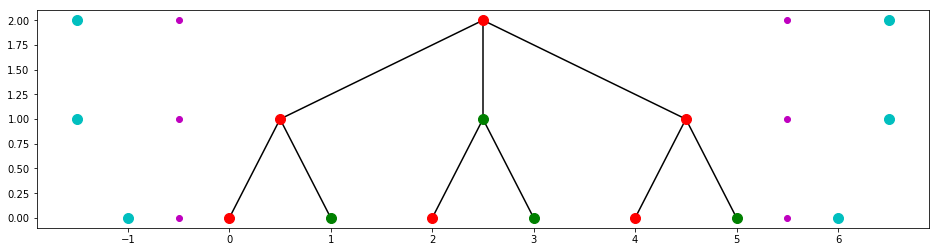

0.375 1.6 0.6
0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


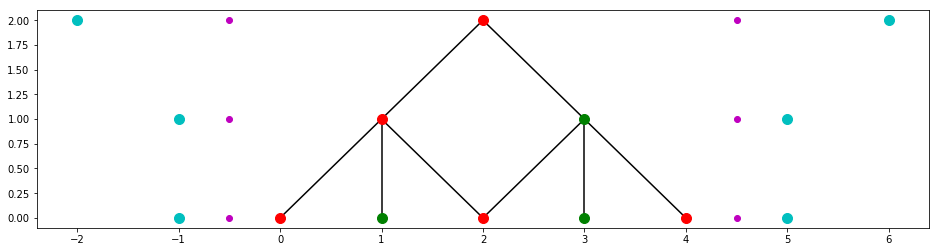

0.5 2.0 1.0
0.5 2.0 1.0
0.5 2.0 1.0


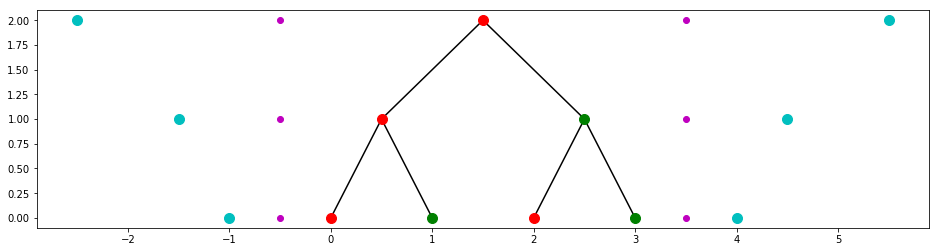

0.25 1.3333333333333333 0.3333333333333333
0.5 2.0 1.0


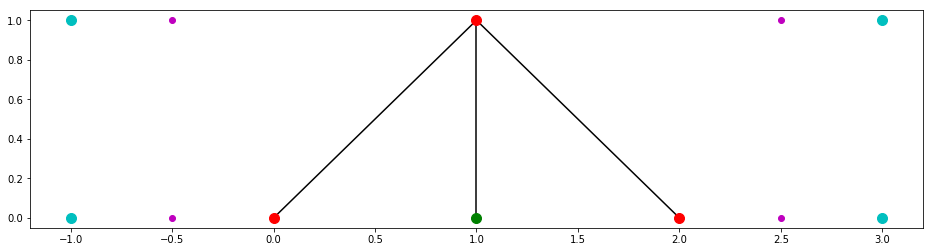

0.5 2.0 1.0
0.5 2.0 1.0


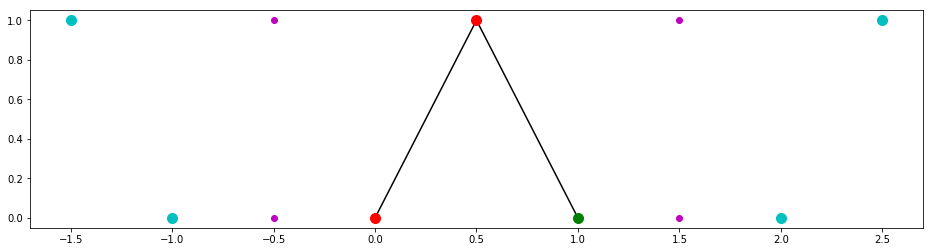

In [22]:
def get_ratio(N, level):
    N = 1*N
    r = 0.5
    for i in range(level):
        d = 1 - N % 2
        N = (N - d) // 2 + d
        r = (r + d*0.5) / 2.0
        
    return r
    

def plot_multigrid(pos, N0, prev_N, level=0, ratio=0.5):
    N = len(pos)
    
    true_ratio = ((-0.5) - (pos[0] - 2**level)) / (pos[0] - (pos[0] - 2**level))
    #print(level, N, N0, ratio, ratio == true_ratio)
    
    # Draw ghost cells
    plt.plot([pos[0] - 2**level], [level], 'oc', ms=10)
    plt.plot([pos[-1] + 2**level], [level], 'oc', ms=10)

    # Draw internal cells
    for i in range(N):
        plt.plot([pos[i]], [level], 'o', color='r' if i%2==0 else "g", zorder=2.5, ms=10)
    
    # Subdivide
    if N > 1:
        next_pos = 0.5 * (pos[0::2] + pos[1::2]) if N % 2 == 0 else pos[1::2]
        # Draw coarsening links
        for i in range(0, len(next_pos)):
            plt.plot([pos[2*i+0], next_pos[i]],[level, level+1], 'k')
            plt.plot([pos[2*i+1], next_pos[i]],[level, level+1], 'k')
            if N % 2 == 1:
                plt.plot([pos[2*i+2], next_pos[i]],[level, level+1], 'k')
        
        # Recurse
        plot_multigrid(next_pos, N0, N, level+1, (ratio + 0.5) / 2.0 if N % 2 == 0 else ratio / 2.0)
    
    # Draw edge cells
    plt.plot([-0.5], [level], 'om')
    plt.plot([N0-0.5], [level], 'om')
    
    # value[-1] * (1 - ratio) + value[0] * ratio = boundary value
    # value[-1] = (boundary_value - value[0] * ratio) / (1 - ratio)
    #
    # value[-1] = -value[0] * ratio / (1 - ratio)
    ratio = get_ratio(N0, level)
    print(ratio, 1 / (1 - ratio), ratio / (1 - ratio))

        
for j in range(17, 1, -1):
    plt.figure(figsize=(16,4))
    positions = numpy.array([i for i in range(j)])
    plot_multigrid(positions, len(positions), len(positions))
    plt.show()
    #print()

# Matrices
### Explicit cell-boundaries

```
  2  -1   0  ...  0   0   0
 -1   2  -1  ...  0   0   0
  0  -1   2  ...  0   0   0
      .     .         .
      .       .       .
      .         .     .
  0   0   0  ...  2  -1   0 
  0   0   0  ... -1   2  -1 
  0   0   0  ...  0  -1   2 
```


### General implicit edge-boundaries
```
  2+r/(1-r)  -1   0  ...  0   0      0
    -1        2  -1  ...  0   0      0
     0       -1   2  ...  0   0      0
              .     .         .
              .       .       .
              .         .     .
     0        0   0  ...  2  -1      0 
     0        0   0  ... -1   2     -1 
     0        0   0  ...  0  -1   2+r/(1-r) 
```

Edge cases: 
```
r = 0   -> r/(1-r) = 0, 
r = 1/2 -> r/(1-r) = 1
```

# Solvers

## 2D Smoother


2.340705394744873 185.5984264879516
0.6284122467041016 185.5984264879516
0.6166784763336182 185.5984264879516


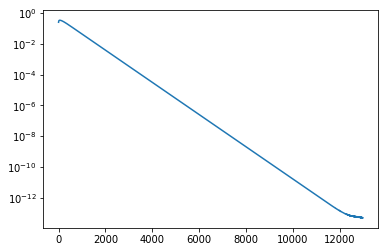

In [7]:
@jit(nopython=True)
def step_gs(x, b):
    for j in range(1, N-1):
        for i in range(1, N-1):
            x[j, i] = (b[j, i] + x[j-1, i] + x[j+1, i] + x[j, i-1] + x[j, i+1]) / 4.0
    return x
    
@jit(nopython=True)
def residual(x, b):
    r = 0.0 * x;
    for j in range(1, N-1):
        for i in range(1, N-1):
            r[j, i] = b[j, i] - (-x[j, i-1] - x[j-1, i] + 4*x[j, i] - x[j+1, i] - x[j, i+1])
    return r;
                
@jit(nopython=True)
def run(x, b):
    N = len(x)
    
    residuals = []
    for z in range(13000):
        x = step_gs(x, b)        
        r = residual(x, b)
        res = numpy.std(r)
        residuals.append(res)
        
    return residuals

for i in range(3):
    N = 65
    x = numpy.zeros((N, N))
    b = numpy.ones((N, N))
    
    t1 = time.time()
    residuals = run(x, b)
    t2 = time.time()
    print(t2-t1, numpy.sum(residuals))
    
    if i == 0: plt.semilogy(residuals)

## 3D Smoother


In [ ]:
@jit(nopython=True)
def run_gs(x, b):
    N = len(x)
    
    residuals = []
    for z in range(13000):
        #if z % 1000 == 0: print(z)
        r = numpy.zeros((N, N, N))
        for k in range(1, N-1):
            for j in range(1, N-1):
                for i in range(1, N-1):
                    x[k, j, i] = (b[k, j, i] + x[k, j-1, i] + x[k, j+1, i] + x[k, j, i-1] + x[k, j, i+1] + x[k-1, j, i] + x[k+1, j, i]) / 6.0
        
        for k in range(1, N-1):
            for j in range(1, N-1):
                for i in range(1, N-1):
                    r[k, j, i] = b[k, j, i] - (-x[k-1, j, i] -x[k, j, i-1] - x[k, j-1, i] + 6*x[k, j, i] - x[k, j+1, i] - x[k, j, i+1] - x[k+1, j, i])
        
        res = numpy.std(r)
        residuals.append(res)
        
    return residuals



for i in range(1):
    N = 65
    x = numpy.zeros((N, N, N))
    b = numpy.ones((N, N, N))
    
    t1 = time.time()
    residuals = run_gs(x, b)
    t2 = time.time()
    print(t2-t1, numpy.sum(residuals))
    
    if i == 0: plt.semilogy(residuals)




## Multigrid


### 1D Multigrid

In [9]:
@jit(nopython=True)
def step_gs(x, b):
    N = len(x)
    for i in range(1, N-1): x[i] = (b[i] + x[i-1] + x[i+1]) / 2.0
    return x
    
@jit(nopython=True)
def step_rbgs(x, b):
    N = len(x)
    for i in range(1, N-1, 2): x[i] = (b[i] + x[i-1] + x[i+1]) / 2.0
    for i in range(2, N-1, 2): x[i] = (b[i] + x[i-1] + x[i+1]) / 2.0
    return x
    
    
@jit(nopython=True)
def residual(x, b):
    N = len(x)
    r = 0.0 * x;
    for i in range(1, N-1):
        r[i] = b[i] - (-x[i-1] + 2*x[i] - x[i+1])
    return r;

@jit(nopython=True)
def coarsen(r):
    c = numpy.zeros((len(r)-1)//2+1)
    N = len(c)
    for i in range(1, N-1):
        c[i] = 0.0
        c[i] += 1.0 * r[2*i-1]
        c[i] += 2.0 * r[2*i+0]
        c[i] += 1.0 * r[2*i+1]
        c[i] /= 4
    return c

@jit(nopython=True)
def interpolate(e):
    N = len(e)
    c = numpy.zeros(2*(N-1)+1)
    #print("from", len(e), "to", len(c))
    
    for i in range(1,N-1):
        c[2*i-1] += 0.5 * e[i]
        c[2*i+0] += 1.0 * e[i]
        c[2*i+1] += 0.5 * e[i]

    return c

@jit(nopython=True)
def cycle(x, b, step_mode):
    N = len(x)

    if N > 3:
        for i in range(1): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)

        r = coarsen(residual(x, b)) * 4.0
        e = cycle(0.0 * r, r, step_mode)
        x += interpolate(e)
        
        for i in range(1): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)
    else:
        for i in range(2*N): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)
    
    return x

@jit(nopython=True)
def run(x, b, step_mode):
    residuals = [numpy.std(residual(x, b))]
    for z in range(20):
        x = cycle(x, b, step_mode)
        r = residual(x, b)
        res = numpy.std(r)
        residuals.append(res)
    
    return residuals, x


#### Sequential Gauss-Seidel smoother

65 0 129 0 257 0 513 0 1025 0 

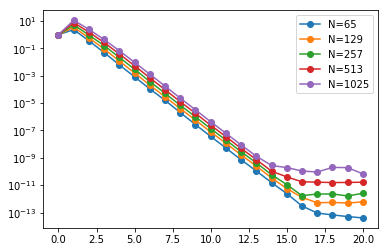

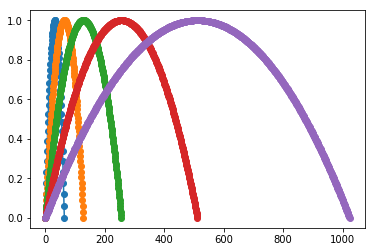

In [10]:
for N in [65, 129, 257, 513, 1025]:
    for i in range(1):
        x = numpy.zeros(N)
        b = 8 * (numpy.ones(N)*1.0 + 0*numpy.random.rand(N)) * (1.0 / (N-1))**2

        print(N, i, "", end="")
        #%timeit residuals, y = run(x, b)
        residuals, y = run(x, b, "gs")
        

    plt.figure(0)
    plt.semilogy(numpy.array(residuals)/residuals[0], 'o-', label="N={}".format(N))
    plt.legend()
    plt.figure(1)
    plt.plot(y, 'o-')

#### Red-Black Gauss-Seidel  smoother

NB: This happens to converge in 1 iteration in 1D...

65 0 129 0 257 0 513 0 1025 0 

c:\python37\lib\site-packages\matplotlib\axes\_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


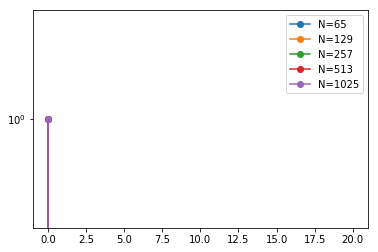

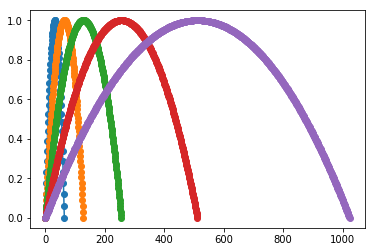

In [11]:
for N in [65, 129, 257, 513, 1025]:
    for i in range(1):
        x = numpy.zeros(N)
        b = 8 * (numpy.ones(N)*1.0 + 0*numpy.random.rand(N)) * (1.0 / (N-1))**2

        print(N, i, "", end="")
        #%timeit residuals, y = run(x, b)
        residuals, y = run(x, b, "rbgs")
        

    plt.figure(0)
    plt.semilogy(numpy.array(residuals)/residuals[0], 'o-', label="N={}".format(N))
    plt.legend()
    plt.figure(1)
    plt.plot(y, 'o-')

### 2D Multigrid

In [4]:
@jit(nopython=True)
def step_gs(x, b):
    N = len(x)
    for j in range(1, N-1): 
        for i in range(1, N-1): 
            x[j][i] = (b[j][i] + x[j][i-1] + x[j][i+1] + x[j-1][i] + x[j+1][i]) / 4.0
    return x
    
@jit(nopython=True)
def step_rbgs(x, b):
    N = len(x)
    for j in range(1, N-1):
        for i in range(1, N-1):
            if (i + j) % 2 == 0:
                x[j][i] = (b[j][i] + x[j][i-1] + x[j][i+1] + x[j+1][i] + x[j-1][i]) / 4.0

    for j in range(1, N-1):
        for i in range(1, N-1):
            if (i + j) % 2 == 1:
                x[j][i] = (b[j][i] + x[j][i-1] + x[j][i+1] + x[j+1][i] + x[j-1][i]) / 4.0

    return x
    
    
@jit(nopython=True)
def residual(x, b):
    N = len(x)
    r = 0.0 * x;
    for j in range(1, N-1):
        for i in range(1, N-1):
            r[j][i] = b[j][i] - (-x[j][i-1] - x[j-1][i] + 4.0 * x[j][i] - x[j][i+1] - x[j+1][i])
    return r;

@jit(nopython=True)
def coarsen(r):
    N = (len(r)-1)//2+1
    c = numpy.zeros((N, N))
    for j in range(1, N-1):
        for i in range(1, N-1):
            c[j][i] = 0.0
            c[j][i] += 1*r[2*j-1][2*i-1]
            c[j][i] += 2*r[2*j+0][2*i-1]
            c[j][i] += 1*r[2*j+1][2*i-1]
            c[j][i] += 2*r[2*j-1][2*i+0]
            c[j][i] += 4*r[2*j+0][2*i+0]
            c[j][i] += 2*r[2*j+1][2*i+0]
            c[j][i] += 1*r[2*j-1][2*i+1]
            c[j][i] += 2*r[2*j+0][2*i+1]
            c[j][i] += 1*r[2*j+1][2*i+1]
            c[j][i] /= 16
    #print("coarsen", len(r), len(r[0]), "->", len(c), len(c[0]))
    return c

@jit(nopython=True)
def interpolate(e):
    N = len(e)
    c = numpy.zeros((2*(N-1)+1, 2*(N-1)+1))
    #print("from", len(e), "to", len(c))
    for j in range(1,N-1):
        for i in range(1,N-1):
            c[2*j-1][2*i-1] += 0.25 * e[j][i]
            c[2*j-1][2*i+0] += 0.50 * e[j][i]
            c[2*j-1][2*i+1] += 0.25 * e[j][i]

            c[2*j+0][2*i-1] += 0.50 * e[j][i]
            c[2*j+0][2*i+0] += 1.00 * e[j][i]
            c[2*j+0][2*i+1] += 0.50 * e[j][i]

            c[2*j+1][2*i-1] += 0.25 * e[j][i]
            c[2*j+1][2*i+0] += 0.50 * e[j][i]
            c[2*j+1][2*i+1] += 0.25 * e[j][i]
    #print("interpolate", len(e), len(e[0]), "->", len(c), len(c[0]))
    return c

@jit(nopython=True)
def cycle(x, b, step_mode):
    N = len(x)
    #print("cycle", N)

    if N > 3:
        for i in range(1): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)

        r = coarsen(residual(x, b)) * 4.0
        e = cycle(0.0 * r, r, step_mode)
        x += interpolate(e)
        
        for i in range(1): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)
    else:
        for i in range(10*N): x = step_gs(x, b) if step_mode == "gs" else step_rbgs(x, b)
    
    return x

@jit(nopython=True)
def run(x, b, step_mode):
    residuals = [numpy.std(residual(x, b))]
    for z in range(20):
        x = cycle(x, b, step_mode)
        r = residual(x, b)
        res = numpy.std(r)
        residuals.append(res)
    
    return residuals, x

#### Sequential Gauss-Seidel

65 0

129 0

257 0

513 0

1025 0



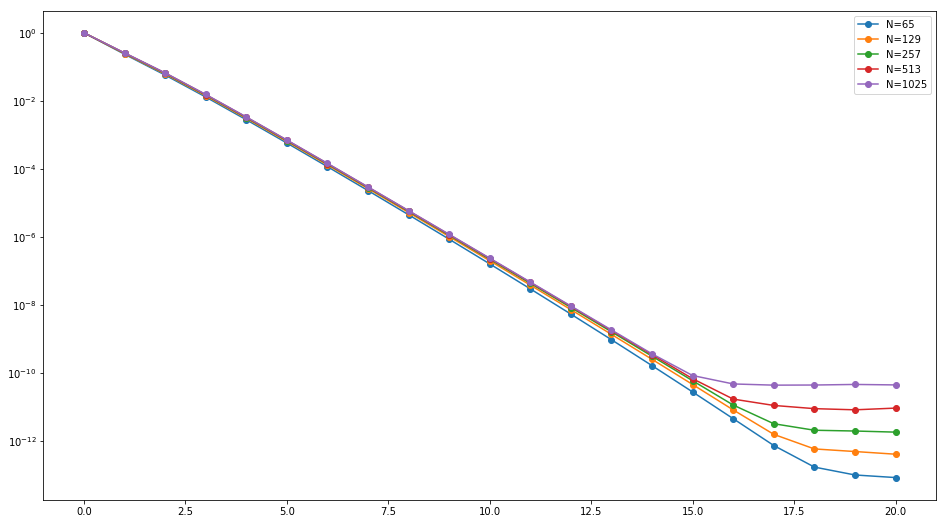

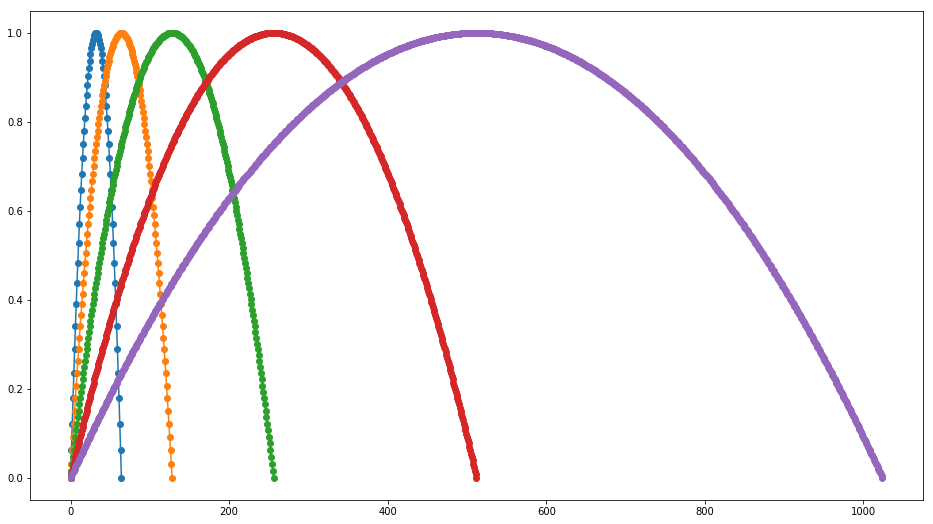

In [5]:

for N in [65, 129, 257, 513, 1025]:
    for i in range(1):
        x = numpy.zeros((N, N))
        if False:
            b = 16 * numpy.ones((N, N))* 1 / (N-1)**2
        else:
            b = numpy.zeros((N, N))
            for xx in range(N):
                for yy in range(N):
                    X = xx / (N - 1)
                    Y = yy / (N - 1)
                    k = yy * N + xx
                    b[yy, xx] = -16 * (2*X*(X-1) + 2*Y*(Y-1)) * 1 / (N-1)**2

        print(N, i)
        #print(N, i, "", end="")
        #%timeit residuals, y = run(x, b, "rbgs")
        residuals, y = run(x, b, "gs")
        print()
        

    plt.figure(0, figsize=(16,9))
    plt.semilogy(numpy.array(residuals)/residuals[0], 'o-', label="N={}".format(N))
    plt.legend()
    plt.figure(1, figsize=(16,9))
    plt.plot(y[len(y)//2,:], 'o-')

#### Red-Black Gauss-Seidel


65 0

129 0

257 0

513 0

1025 0



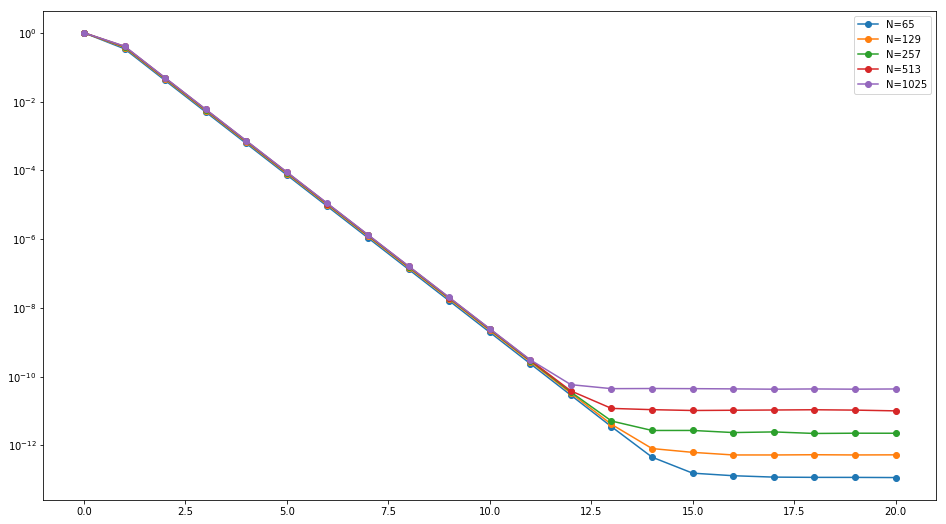

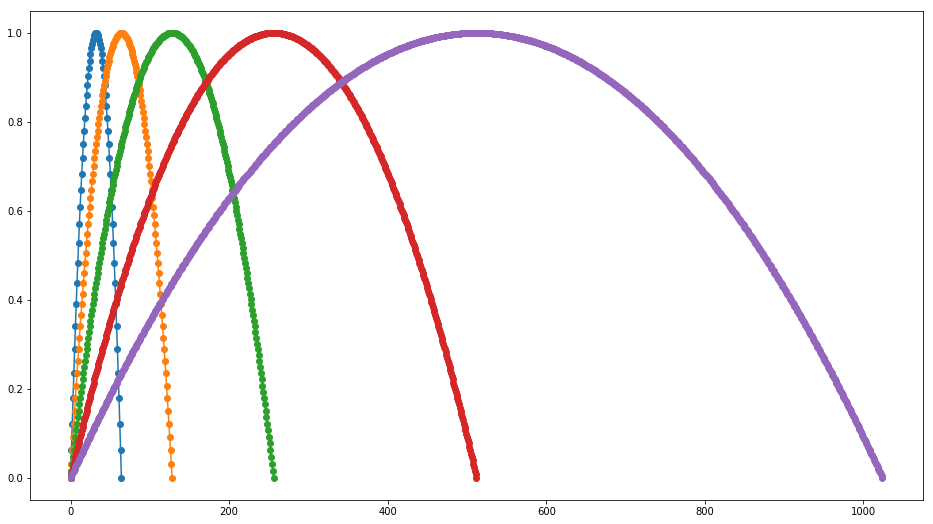

In [7]:

for N in [65, 129, 257, 513, 1025]:
    for i in range(1):
        x = numpy.zeros((N, N))
        if False:
            b = 16 * numpy.ones((N, N))* 1 / (N-1)**2
        else:
            b = numpy.zeros((N, N))
            for xx in range(N):
                for yy in range(N):
                    X = xx / (N - 1)
                    Y = yy / (N - 1)
                    k = yy * N + xx
                    b[yy, xx] = -16 * (2*X*(X-1) + 2*Y*(Y-1)) * 1 / (N-1)**2

        print(N, i)
        #print(N, i, "", end="")
        #%timeit residuals, y = run(x, b, "rbgs")
        residuals, y = run(x, b, "rbgs")
        print()
        

    plt.figure(0, figsize=(16,9))
    plt.semilogy(numpy.array(residuals)/residuals[0], 'o-', label="N={}".format(N))
    plt.legend()
    plt.figure(1, figsize=(16,9))
    plt.plot(y[len(y)//2,:], 'o-')